Всего было найдено в общей сложности 4 датасета: гены шимпанзе, собаки и человека (kaggle) и просто гены человека (huggingface). Во всех имеющихся датасетах присутствуют два необходимых для исследования столбца: сама последовательность и класс гена, который она кодирует. Отсюда возникает проблема, не позволяющая объединить все датасеты в один: во всех имеющихся источниках последовательности разделены на не пересекающиеся между собой классы, поэтому в дальнейшем целесообразнее всего использовать три датасета, найденных на kaggle.
Прежде всего, необходимо загрузить данные. Это можно сделать при помощи API проекта kaggle.

Данные с huggingface были загружены в ручную из-за проблем с работой API.

In [11]:
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import sys
sys.setrecursionlimit(1000000)

In [5]:
dna_huggingface = pd.read_parquet("test-00000-of-00001.parquet")
dna_huggingface.describe

<bound method NDFrame.describe of            Entry                                           Sequence  \
0     BGC0000476  CCAACCAACATATGAACAAGAAGAACATTCTACCCCAACAAGGCCA...   
1     BGC0001412  CAGCTGCAATTGTTCGTAACCAAACGAAACGACTGCCATCACTACC...   
2     BGC0001669  AGCTCCGTCGCGACGGCCGCGGCGCTGACGACCAGAACCGCTACTC...   
3     BGC0002337  TCAGGTGACGAGGCCGAGCCGCGGTCCGCCCCCATGGCGCAGCCGT...   
4     BGC0001769  GTGAGCGCGATCCGGCAACGCACCCGTGTCGGTGGTGGGCCTCTGG...   
...          ...                                                ...   
1758  BGC0001728  TTGTCGGAAACAGAAAAGAAAGATGCATTGCAAGTGTTAAGAAGGA...   
1759  BGC0001608  ATGAACAGATACGAAACCGTGAGGCGAGTCGAGTCGAATGCCAGAA...   
1760  BGC0000958  TCAGGCGGCGGTGGGCTGCCATGCCTCCTGGAAGCGGCGGCGGGCC...   
1761  BGC0002232  TCTGTCCCTTTTCTTCTCCGTTTGGCTTCTTGTATCGCTGACGGTT...   
1762  BGC0001700  TCATCGCCGGTCTCCTCGGCGCCCTCTGCCCTCGGACGGCTTCTTC...   

             bgc            class simple_class  
0     BGC0000476             RiPP         RiPP  
1     BGC000141

В данных много лишних столбцов, которые необходимо удалить.

In [7]:
dna_huggingface = pd.read_parquet("test-00000-of-00001.parquet")
dna_huggingface = dna_huggingface.drop(columns = ["class", "Entry", "bgc"]).rename(columns = {"simple_class" : "class", "Sequence" : "sequence"})
dna_huggingface.describe

<bound method NDFrame.describe of                                                sequence       class
0     CCAACCAACATATGAACAAGAAGAACATTCTACCCCAACAAGGCCA...        RiPP
1     CAGCTGCAATTGTTCGTAACCAAACGAAACGACTGCCATCACTACC...  Saccharide
2     AGCTCCGTCGCGACGGCCGCGGCGCTGACGACCAGAACCGCTACTC...        RiPP
3     TCAGGTGACGAGGCCGAGCCGCGGTCCGCCCCCATGGCGCAGCCGT...        RiPP
4     GTGAGCGCGATCCGGCAACGCACCCGTGTCGGTGGTGGGCCTCTGG...  Polyketide
...                                                 ...         ...
1758  TTGTCGGAAACAGAAAAGAAAGATGCATTGCAAGTGTTAAGAAGGA...         NRP
1759  ATGAACAGATACGAAACCGTGAGGCGAGTCGAGTCGAATGCCAGAA...         NRP
1760  TCAGGCGGCGGTGGGCTGCCATGCCTCCTGGAAGCGGCGGCGGGCC...         NRP
1761  TCTGTCCCTTTTCTTCTCCGTTTGGCTTCTTGTATCGCTGACGGTT...    Alkaloid
1762  TCATCGCCGGTCTCCTCGGCGCCCTCTGCCCTCGGACGGCTTCTTC...  Polyketide

[1763 rows x 2 columns]>

После небольшой очистки от лишних столбцов датасет с huggingface приобрел нужный вид.

Далее рассмотрим соберем датасеты с kaggle, проведем базовую предобработку (удаление пустых и повторяющихся строк) и сохраним их в базу данных sqlite3.

In [3]:
dna_kaggle_human = pd.read_table("human.txt")
dna_human = dna_kaggle_human.drop_duplicates().dropna()
dna_human.reset_index(drop=True, inplace=True)
dna_kaggle_dog = pd.read_table("dog.txt")
dna_dog = dna_kaggle_dog.drop_duplicates().dropna()
dna_dog.reset_index(drop=True, inplace=True)
dna_kaggle_monke = pd.read_table("chimpanzee.txt")
dna_monke = dna_kaggle_monke.drop_duplicates().dropna()
dna_monke.reset_index(drop=True, inplace=True)

Dataset URL: https://www.kaggle.com/datasets/nageshsingh/dna-sequence-dataset


Как можно заметить, все три датасета с kaggle имеют общий вид и, более того, категориальные данные в них уже закодированы с помощью целых чисел от 0 до 6. Можно построить расшифровку, используя известные метаданные о датасетах.

In [9]:
dna_human.to_csv("human.csv")
dna_monke.to_csv("chimp.csv")
dna_dog.to_csv("dog.csv")

In [193]:
map_dict = {0 : "G protein coupled receptors", 1 : "Tyrosine kinase", 2 : "Tyrosine phosphate", 3 : "Synthetase", 4 : "Synthase", 5 : "Ion channel", 6 : "Transcription factor"}

In [196]:
dna_human["classname"] = dna_human["class"].map(map_dict)
dna_dog["classname"] = dna_dog["class"].map(map_dict)
dna_monke["classname"] = dna_monke["class"].map(map_dict)

In [198]:
print(dna_human["classname"].unique())
print(dna_dog["classname"].unique())
print(dna_monke["classname"].unique())

['Synthase' 'Synthetase' 'Ion channel' 'Tyrosine phosphate'
 'Transcription factor' 'G protein coupled receptors' 'Tyrosine kinase']
['Synthase' 'Transcription factor' 'G protein coupled receptors'
 'Synthetase' 'Tyrosine phosphate' 'Ion channel' 'Tyrosine kinase']
['Synthase' 'Transcription factor' 'G protein coupled receptors'
 'Tyrosine kinase' 'Synthetase' 'Tyrosine phosphate' 'Ion channel']


Теперь можно сравнить с уникальными классами в датасете с huggingface.

In [200]:
print(dna_huggingface["class"].unique())

['RiPP' 'Saccharide' 'Polyketide' 'NRP' 'Terpene' 'Alkaloid']


Как видно, множество классов не совпадает, объединение датасетов возможно, но не целесообразно в рамках данной задачи. Так как в последствии планируется обученную на человеческих данных модель протестировать так же на данных для шимпанзе и собаки. Далее необходимо произвести исследовательский анализ данных.

Число последовательностей каждого класса для человека
classname
Transcription factor           1109
Synthase                        590
Synthetase                      570
G protein coupled receptors     446
Tyrosine kinase                 408
Tyrosine phosphate              291
Ion channel                     215
Name: count, dtype: int64


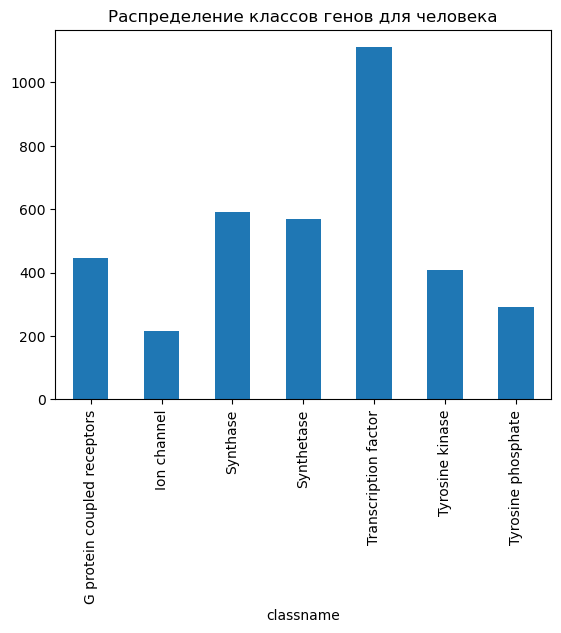

In [202]:
print('Число последовательностей каждого класса для человека')
print(dna_human["classname"].value_counts())

dna_human["classname"].value_counts().sort_index().plot.bar()
plt.title("Распределение классов генов для человека")
plt.savefig("class_dist_human.png")

Число последовательностей каждого класса для шимпанезе
classname
Transcription factor           518
Synthase                       259
G protein coupled receptors    233
Synthetase                     228
Tyrosine kinase                185
Tyrosine phosphate             144
Ion channel                    108
Name: count, dtype: int64


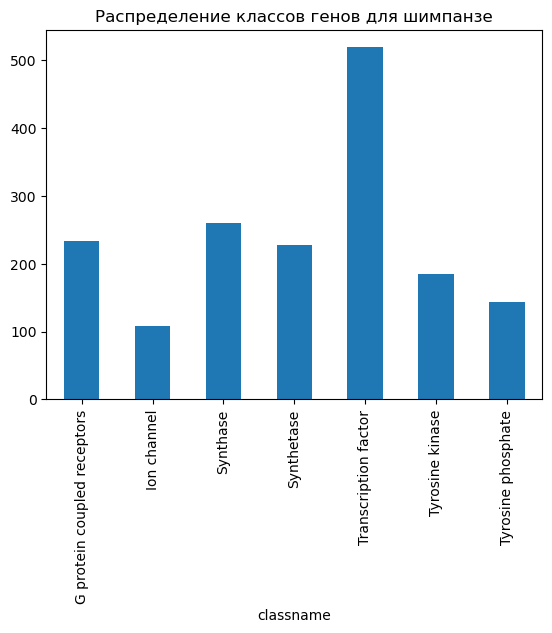

In [204]:
print('Число последовательностей каждого класса для шимпанезе')
print(dna_monke["classname"].value_counts())

dna_monke["classname"].value_counts().sort_index().plot.bar()
plt.title("Распределение классов генов для шимпанзе")
plt.savefig("class_dist_monke.png")

Число последовательностей каждого класса для собаки
classname
Transcription factor           259
Synthase                       134
G protein coupled receptors    131
Synthetase                      94
Tyrosine kinase                 75
Tyrosine phosphate              64
Ion channel                     60
Name: count, dtype: int64


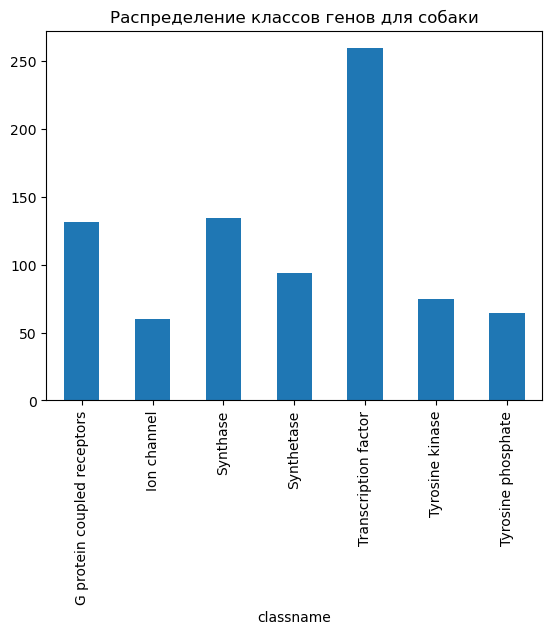

In [206]:
print('Число последовательностей каждого класса для собаки')
print(dna_dog["classname"].value_counts())

dna_dog["classname"].value_counts().sort_index().plot.bar()
plt.title("Распределение классов генов для собаки")
plt.savefig("class_dist_dog.png")

Как видно из графиков, наиболее представлен класс фактора транскрипции под номером 6, поэтому для дальнейшего определения параметров для модели будет использован именно он.

Модель планируется обучать схожим с NLP образом, а потому все последовательности нужно будет разбить на k-меры определенной длины, чтобы определить оптимальную длину, построим графики количества k-меров разной длины

Функция для подсчета.

In [211]:
def recursive_count(string, substring, start=0, count=0):
    index = string.find(substring, start)
    if index != -1:
        return recursive_count(string, substring, index + len(substring), count + 1)
    return count

Функция для генерации всех возможных k-меров.

In [214]:
def generate_combinations(sequence, length):
    return [''.join(combination) for combination in product(sequence, repeat=length)]

Подсчет количества раз, когда был встречен тот или иной k-мер и построение графиков.

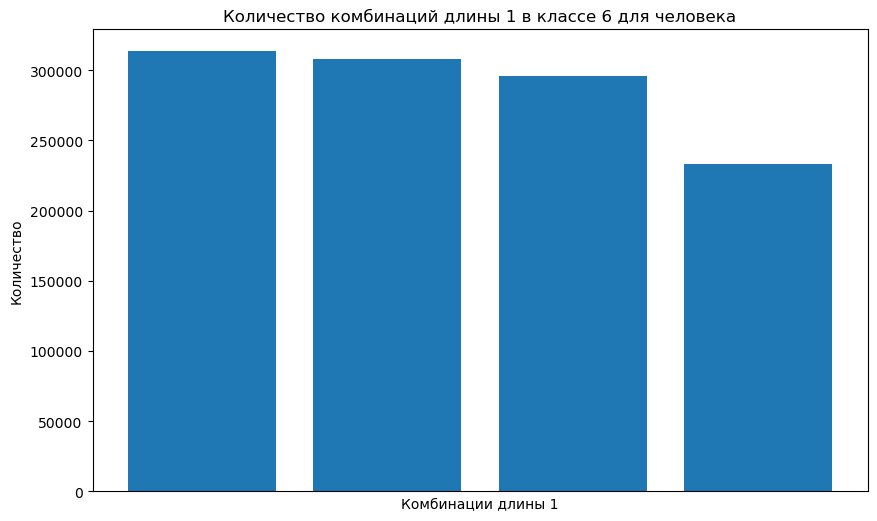

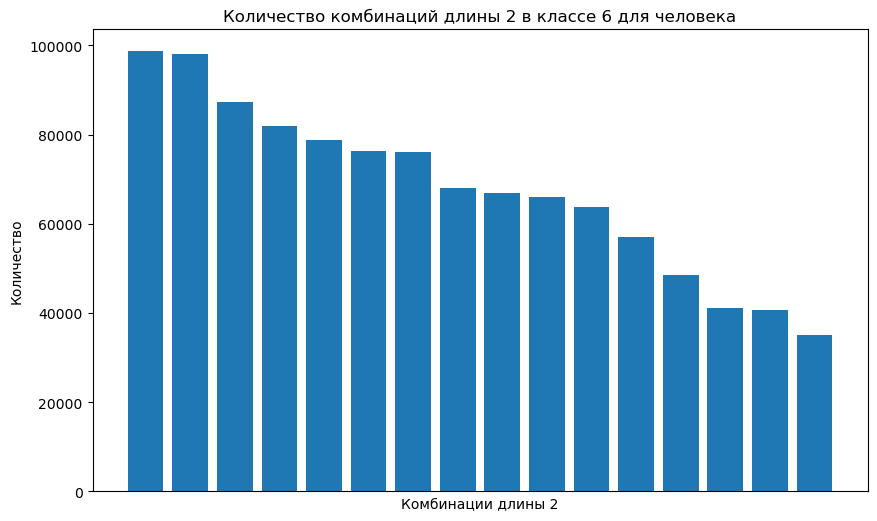

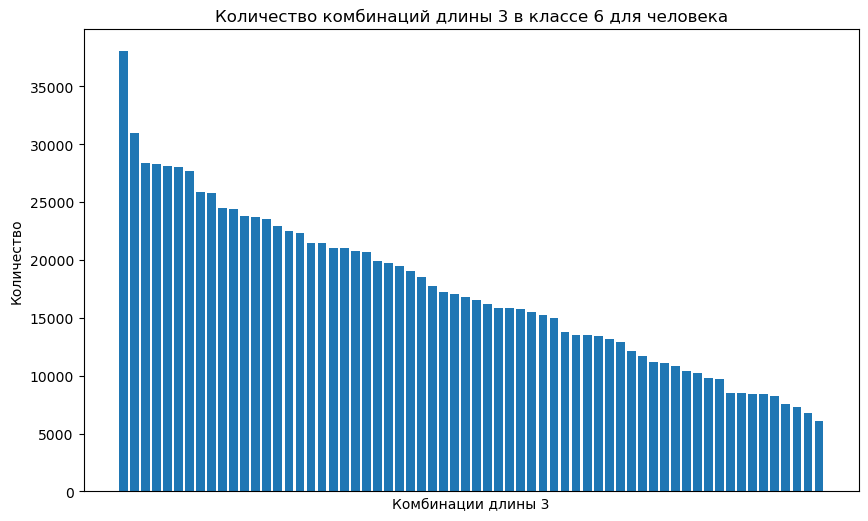

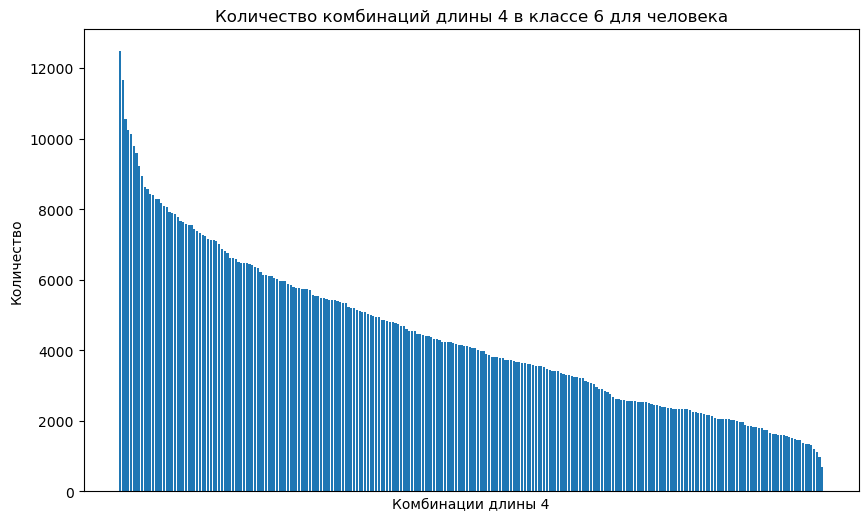

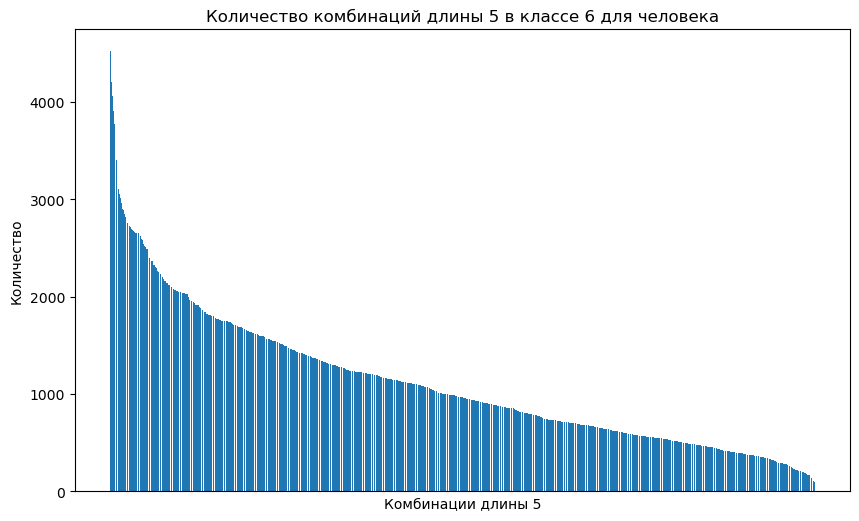

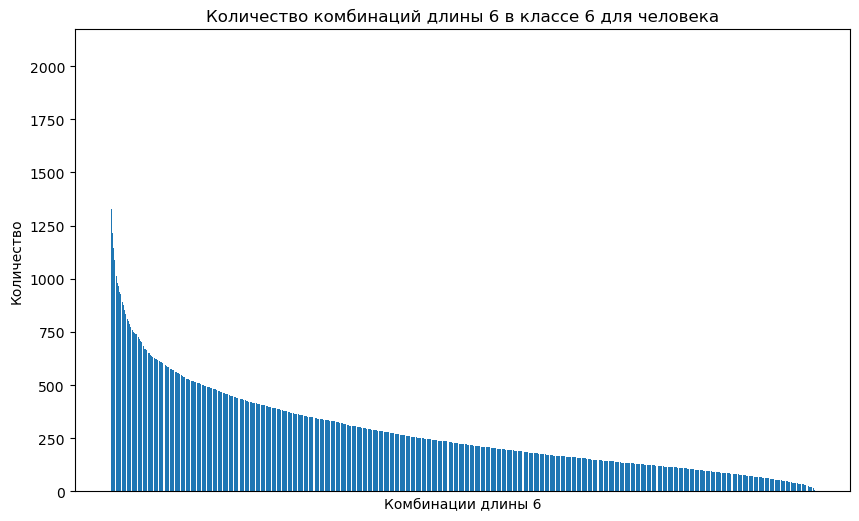

In [217]:
class_ = 6
for k in range(1, 7):
    nucleotides = ['A', 'C', 'G', 'T']
    combinations = generate_combinations(nucleotides, k)  #генерируем k-меры
    sequence = ''.join(dna_human[dna_human['class'] == class_]['sequence']) #соединяем все последовательности класса в одну длинную последовательность для подсчета в ней количества k-меров
    sequence_count = [recursive_count(sequence, combination) for combination in combinations] #подсчитываем, сколько раз встретился k-мер
    sequence_count_ = sorted(zip(combinations, sequence_count), key=lambda x: x[1], reverse=True) #сортируем
    sequence_count_df = pd.DataFrame(sequence_count_, columns=['combination', 'count'])
    sequence_count_df.to_csv('human_class_{}_{}_mer_counts.csv'.format(class_, k), index=False) #создаем датафрейм и сохраняем его как csv
    #построение графиков
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sequence_count_)), [count for _, count in sequence_count_], align='center',antialiased=True)
    plt.xlabel('Комбинации длины {}'.format(k))
    plt.ylabel('Количество')
    plt.xticks([])
    plt.title('Количество комбинаций длины {} в классе {} для человека'.format(k, class_))
    #сохранение графиков
    plt.savefig('human_class_{}_{}_mer_counts.png'.format(class_, k), dpi=300)

Видно, что с увеличением k, k-меры образуют все более различимые признаки. Исходя из этого, для обучения модели целесообразно брать 6-меры (гексомеры).

Перейдем к обучению модели и подбору параметров.

Удалим добавленный для читаемости столбец classname.

In [114]:
dna_human = dna_human.drop("classname", axis = 1)
dna_dog = dna_dog.drop("classname", axis = 1)
dna_monke = dna_monke.drop("classname", axis = 1)

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0
...,...,...
812,ATGGTCGGTCCGGAGAAGGAGCAGAGCTGGATCCCTAAGATCTTCA...,5
813,ATGGCGGCGACGGTGGCTGCGGCGGCCGCCGACGCGGGGCCGGGGG...,6
814,ATGAGCTCGGCCGACAAGGCCCGGGTGGGGCCCGCGGCCGACGGGC...,6
815,GCCCCGAGGATGGGCAGGGTCCCGCTGGCCTGGTGCTTGGCGCTGT...,1


Функция для разбиения последовательности на 6-меры.

In [13]:
def hexamers(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

Применим эту функцию ко всем трем датасетам. Добавим столбец hexamers и удалим столбец sequence.

In [15]:
dna_human['hexamers'] = dna_human.apply(lambda x: hexamers(x['sequence']), axis=1)
dna_human = dna_human.drop('sequence', axis=1)
dna_dog['hexamers'] = dna_dog.apply(lambda x: hexamers(x['sequence']), axis=1)
dna_dog = dna_dog.drop('sequence', axis=1)
dna_monke['hexamers'] = dna_monke.apply(lambda x: hexamers(x['sequence']), axis=1)
dna_monke = dna_monke.drop('sequence', axis=1)

Последовательности приведены в нижний регистр и разбиты на гексамеры. Теперь необходимо конвертировать списки гексамеров в строки для каждого гена, чтобы в последствии использовать данные для обучения модели типа "Мешок Слов". Так же сделаем целевую переменную y, которая содержит индикаторы классов.

In [17]:
human_hexmers = list(dna_human['hexamers'])
for item in range(len(human_hexmers)):
    human_hexmers[item] = ' '.join(human_hexmers[item])
y_human = dna_human.iloc[:, 0].values

dog_hexmers = list(dna_dog['hexamers'])
for item in range(len(dog_hexmers)):
    dog_hexmers[item] = ' '.join(dog_hexmers[item])
y_dog = dna_dog.iloc[:, 0].values

monke_hexmers = list(dna_monke['hexamers'])
for item in range(len(monke_hexmers)):
    monke_hexmers[item] = ' '.join(monke_hexmers[item])
y_monke = dna_monke.iloc[:, 0].values

Создаем модель типа "Мешок Слов" при помощи функции Countvectorizer(). Размер n-грамм равен 4 и принят на основе существующих статей (https://doi.org/10.1016/j.patcog.2005.05.002). Конвертируем гексамеры в векторы одинаковой длины, которые представляют количество случаев встречи определенного гексамера.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) 
X_human = cv.fit_transform(human_hexmers)
X_monke = cv.transform(monke_hexmers)
X_dog = cv.transform(dog_hexmers)

In [20]:
print(X_human.shape)
print(X_monke.shape)
print(X_dog.shape)

(3629, 232414)
(1675, 232414)
(817, 232414)


Теперь можно построить саму модель, которая будет классифицировать ДНК-последовательность. Для обучения используется 80% данных для человека. После разделения на тренировочные и тестовые данные, будет построен наивный мультиномиальный байессовский классификатор.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_human, y_human, test_size = 0.20, random_state=42)

Далее создаем классификатор.

In [22]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Предсказываем на тестовых данных.

In [23]:
y_pred = classifier.predict(X_test)

Оцениваем по метрикам.

Доля правильно классифицированных = 0.949 
Точность = 0.953 
Полнота = 0.949 
F1 = 0.949


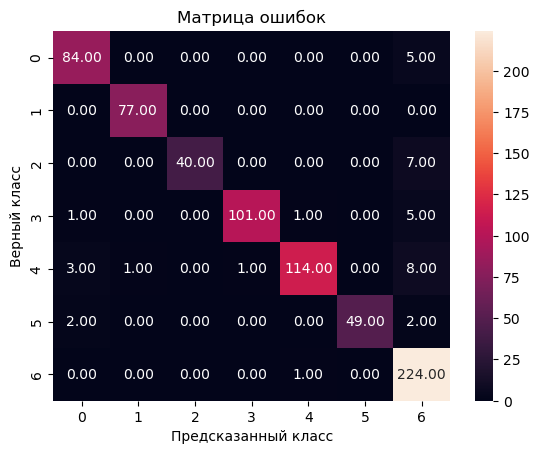

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

def metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = metrics(y_test, y_pred)
print("Доля правильно классифицированных = %.3f \nТочность = %.3f \nПолнота = %.3f \nF1 = %.3f" % (accuracy, precision, recall, f1))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f')
plt.xlabel('Предсказанный класс')
plt.ylabel('Верный класс')
plt.title('Матрица ошибок')
plt.savefig("human_test_confusion.png")
plt.show()

Теперь протестируем модель на данных для других организмов.

Шимпанзе.

Доля правильно классифицированных = 0.989 
Точность = 0.989 
Полнота = 0.989 
F1 = 0.989


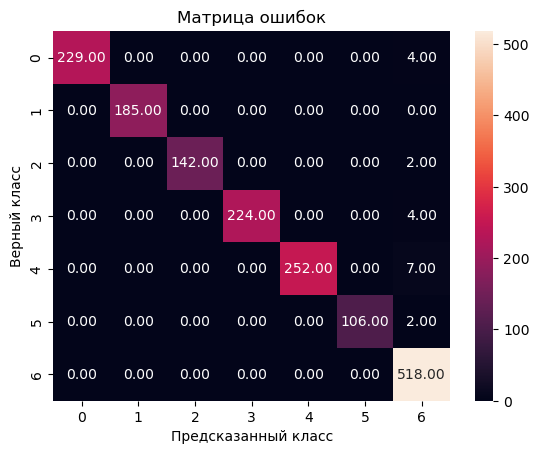

In [31]:
y_pred_monke = classifier.predict(X_monke)
accuracy, precision, recall, f1 = metrics(y_monke, y_pred_monke)
print("Доля правильно классифицированных = %.3f \nТочность = %.3f \nПолнота = %.3f \nF1 = %.3f" % (accuracy, precision, recall, f1))
sns.heatmap(confusion_matrix(y_monke, y_pred_monke), annot=True, fmt='.2f')
plt.xlabel('Предсказанный класс')
plt.ylabel('Верный класс')
plt.title('Матрица ошибок')
plt.savefig("chimp_test_confusion.png")
plt.show()

Собака.

Доля правильно классифицированных = 0.920 
Точность = 0.933 
Полнота = 0.920 
F1 = 0.921


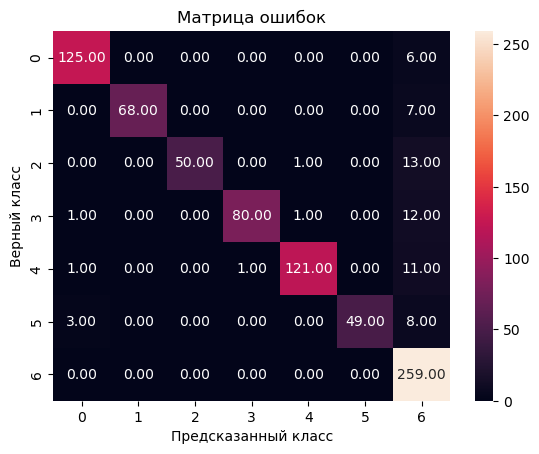

In [33]:
y_pred_dog = classifier.predict(X_dog)
accuracy, precision, recall, f1 = metrics(y_dog, y_pred_dog)
print("Доля правильно классифицированных = %.3f \nТочность = %.3f \nПолнота = %.3f \nF1 = %.3f" % (accuracy, precision, recall, f1))
sns.heatmap(confusion_matrix(y_dog, y_pred_dog), annot=True, fmt='.2f')
plt.xlabel('Предсказанный класс')
plt.ylabel('Верный класс')
plt.title('Матрица ошибок')
plt.savefig("dog_test_confusion.png")
plt.show()

Неплохие результаты для данных человека и шимпанзе, что можно обяснить близкой видовой принадлежностью. Заметно хуже результаты для данных собаки из-за того, что собака куда удаленнее от приматов в генетическом плане.